In [1]:
import umap
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import chromadb
from chromadb.config import Settings
# pip install umap-learn


db = chromadb.PersistentClient(path="../tests", settings=Settings(anonymized_telemetry=False))

collection = db.get_collection(name="test_collection")

embeddings = collection.get(include=['embeddings', 'documents'])

Add of existing embedding ID: 1


In [2]:
embeddings['documents'][100]

'or not the characters are balanced," expressing that "some characters are naturally better, but no character is so overpowered that their mere presence spells doom for their opponents."[77] In June 2016, Vulture\'s Joshua Rivera listed Overwatch as one of the "best video games of 2016 (so far)," writing, "It\'s hard to separate Overwatch the game from Overwatch the phenomenonâ€”and why bother, both are fascinating."[78]'

In [3]:
np_embeddings = np.array(embeddings['embeddings'])
np_embeddings.shape

(142, 384)

100%|██████████| 142/142 [03:48<00:00,  1.61s/it]


(0.9180423319339752, 13.23548075556755, 4.3716134309768675, 11.430249762535095)

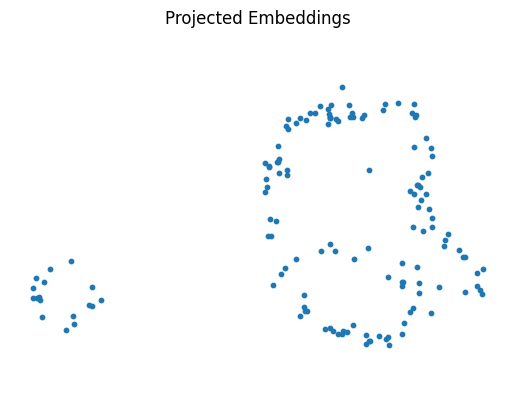

In [4]:
umap_transform = umap.UMAP().fit(np_embeddings)

def project_embeddings(embeddings, umap_transform):
    umap_embeddings = np.empty((len(embeddings),2))
    for i, embedding in enumerate(tqdm(embeddings)):
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings

projected_dataset_embeddings = project_embeddings(embeddings['embeddings'], umap_transform)

In [5]:
import torch
import torch.nn.functional as F
from transformers import AutoModel, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")


# Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]  # First element of model_output contains token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(
        input_mask_expanded.sum(1), min=1e-9
    )


def get_sentence_embedding(sentence: str):
    encoded_input = tokenizer(sentence, padding=True, truncation=True, return_tensors="pt")

    with torch.no_grad():
        model_output = model(**encoded_input)

    sentence_embeddings = mean_pooling(model_output, encoded_input["attention_mask"])
    sentence_embeddings = sentence_embeddings.flatten()
    return F.normalize(sentence_embeddings, p=2, dim=0)

c:\Users\tzbk\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [9]:
query = "What is overwatch 2?"

results = collection.query(query_texts=query, n_results=3, include=['documents', 'embeddings'])

query_embedding = get_sentence_embedding([query])
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


In [10]:
db_documents = []
for x in embeddings['documents']:
    result = ''
    for i in range(0, len(x), 70):
        result += x[i:i+70] + '<br>'
    db_documents.append(result)

In [17]:
import plotly.graph_objects as go

# Scatter plot for database embeddings
scatter_dataset = go.Scatter(
    x=projected_dataset_embeddings[:, 0],
    y=projected_dataset_embeddings[:, 1],
    mode='markers',
    marker=dict(size=10, color='gray'),
    name='Dataset Embeddings',
    hovertext=db_documents,
    hoverinfo='text',
    hoverlabel = dict(font=dict(color='white'))
)

# Scatter plot for query embedding
scatter_query = go.Scatter(
    x=[projected_query_embedding[0, 0]],
    y=[projected_query_embedding[0, 1]],
    mode='markers',
    marker={"size":25, "color":'red', "symbol":'x'},
    name='Query Embedding',
    hovertext=query,
    hoverinfo='text'
)

# Scatter plot for retrieved embeddings
scatter_retrieved = go.Scatter(
    x=projected_retrieved_embeddings[:, 0],
    y=projected_retrieved_embeddings[:, 1],
    mode='markers',
    marker=dict(size=15, color='orange', symbol='circle'),
    name='Retrieved Embeddings',
    hovertext=results['documents'][0],
    hoverinfo='text'
)

# Define layout
layout = go.Layout(
    title=query,
    xaxis=dict(visible=False),
    yaxis=dict(visible=False)
)

# Create figure
fig = go.Figure(data=[scatter_dataset, scatter_query, scatter_retrieved], layout=layout)

# Display plot
fig.show()
